# Monte Carlo Simulation

This Notebooks introduces the Monte Carlo method for pricing financial derivatives. We will start with the basic Monte Carlo method and then move on to more advanced methods. 

They are used to price derivatives for which an analytical solution cannot be found. The basic idea is to simulate the underlying asset price at the maturity of the derivative and then calculate the payoff of the derivative. The price of the derivative is then the average of the payoffs discounted to the present time. 

$$E[e^{-r(T-t)} f(S_T) | S_t = S] \approx \frac{1}{M} \sum_{i=1}^M e^{-r(T-t)} f(S_T^{(i)})$$

where $S_T^{(i)}$ is the simulated asset price at maturity and $f(S_T^{(i)})$ is the payoff of the derivative.

The Monte Carlo method is a very general method and can be used to price a wide range of derivatives. However, it is also a very slow method and requires a lot of computational power. Therefore, we will also look at variance reduction techniques that can be used to speed up the Monte Carlo method in the next notebooks.

$\textbf{Theory from a lecture at LMU by Dr. Ari-Pekka Perkkiö}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import fima

In [2]:
T = 1
t = 0
x = 100
r = 0.05
sigma = 0.2

In [3]:
def basic_mc(t, x, eta, payoff, r, sigma, T):
    assets = fima.GBMpaths(x, r, sigma, T - t, eta)

    payoffs = np.exp(-r*(T-t)) * payoff(assets)

    means = np.cumsum(payoffs) / np.arange(1, len(payoffs) + 1)

    #we should do this but this is way to slow in python if implemented like this
    #interval_range = 1.96 * ([np.std(payoffs[:n]) for n in range(1, len(payoffs) + 1)] / np.sqrt(np.arange(1, len(payoffs) + 1)))
    #so we do this instead
    interval_range = 1.96 * np.std(payoffs) / np.sqrt(np.arange(1, len(payoffs) + 1))

    return means, interval_range

In [4]:
M = 1000000
eta = np.random.normal(size = (1, M))

In [5]:
K = 110

true_price = fima.BS_call_price(t=t, x=x, K=K, r=r, sigma=sigma, T = T)
basic_means, basic_interval_range = basic_mc(t = t, x = x, eta = eta, payoff = lambda x : fima.european_call_payoff(x, K), r = r, sigma = sigma, T = T)

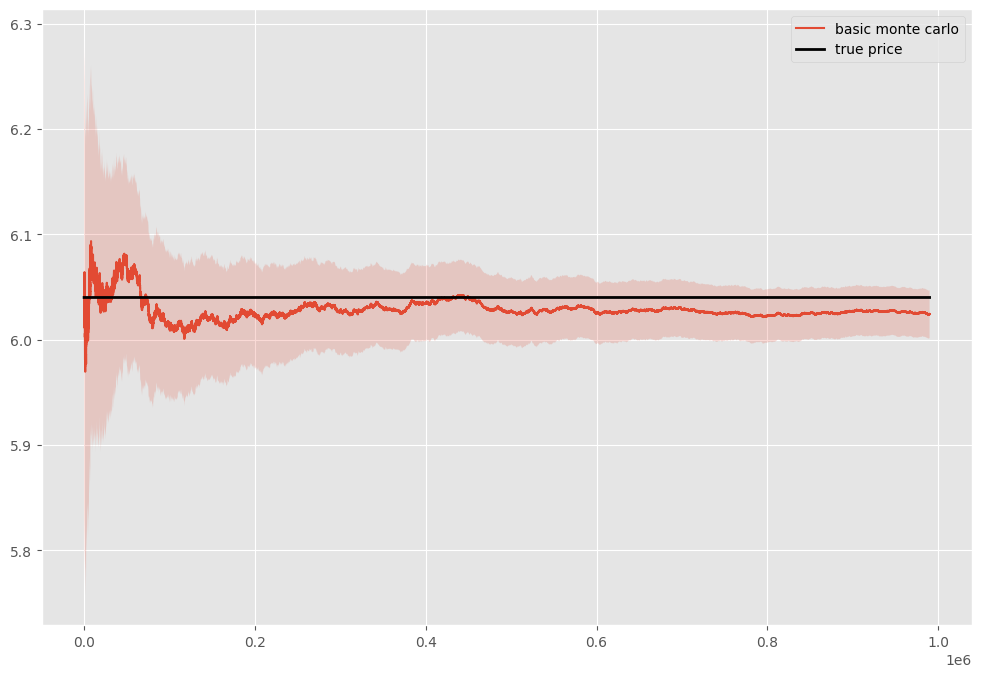

In [6]:
fima.plot_mc(basic_means, basic_interval_range, 'basic monte carlo')
fima.plot_true_price(true_price, len(basic_means))
plt.legend();

Note the Saw tooth patter in the plot below. This is due to the fact that we increased the strike price of the option from 110 to 220. This means that a lot less simulations end up in the money so we have long times where the mc_price decreases and then when the option is in the money the mc_price increases by a large amount.

In [7]:
K = 220

true_price = fima.BS_call_price(t=t, x=x, K=K, r=r, sigma=sigma, T = T)
basic_means, basic_interval_range = basic_mc(t = t, x = x, eta = eta, payoff =  lambda x : fima.european_call_payoff(x, K), r = r, sigma = sigma, T = T)

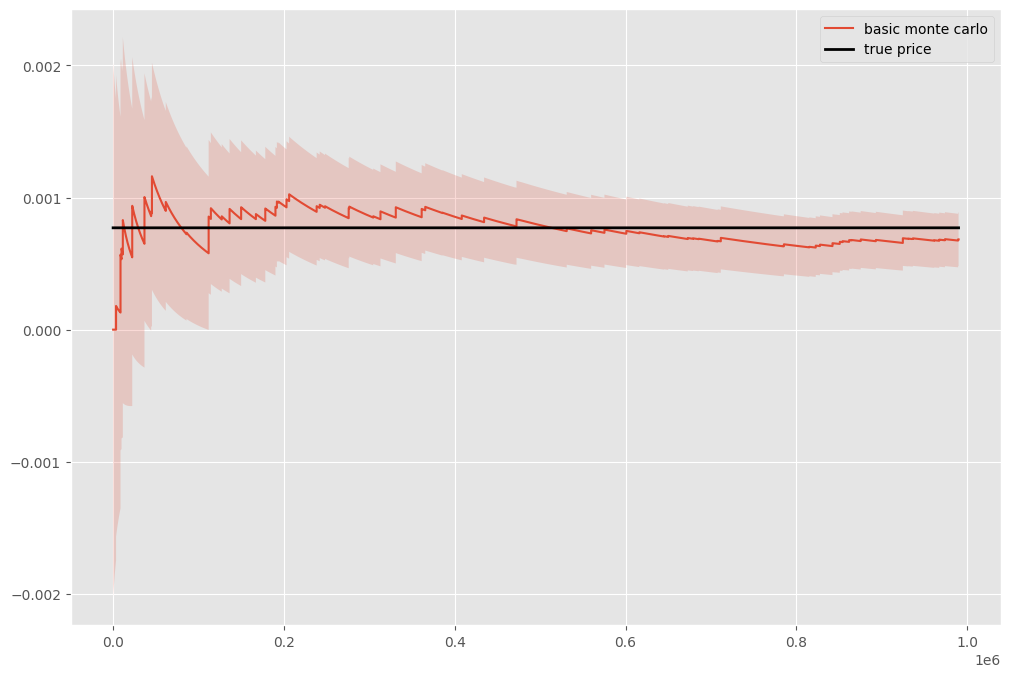

In [8]:
fima.plot_mc(basic_means, basic_interval_range, 'basic monte carlo')
fima.plot_true_price(true_price, len(basic_means))
plt.legend();

In [9]:
def asian_call_payoff(S, K):
    return np.maximum(np.mean(S, axis=0) - K, 0)

def asian_put_payoff(S, K):
    return np.maximum(K - np.mean(S, axis=0), 0)

In [10]:
t = 0
K = 1.1
r = 0.05
sigma = [0.01, 0.1, 0.2, 0.3]

In [11]:
n = 1000
m = 2000

eta = np.random.normal(size = (n, m))

In [12]:
x = np.linspace(0, 1.5, 100)

y = [[basic_mc(t, x0, eta, payoff = lambda S : asian_call_payoff(S, K), r = r, sigma = s, T = T)[0][-1] for s in sigma] for x0 in x]

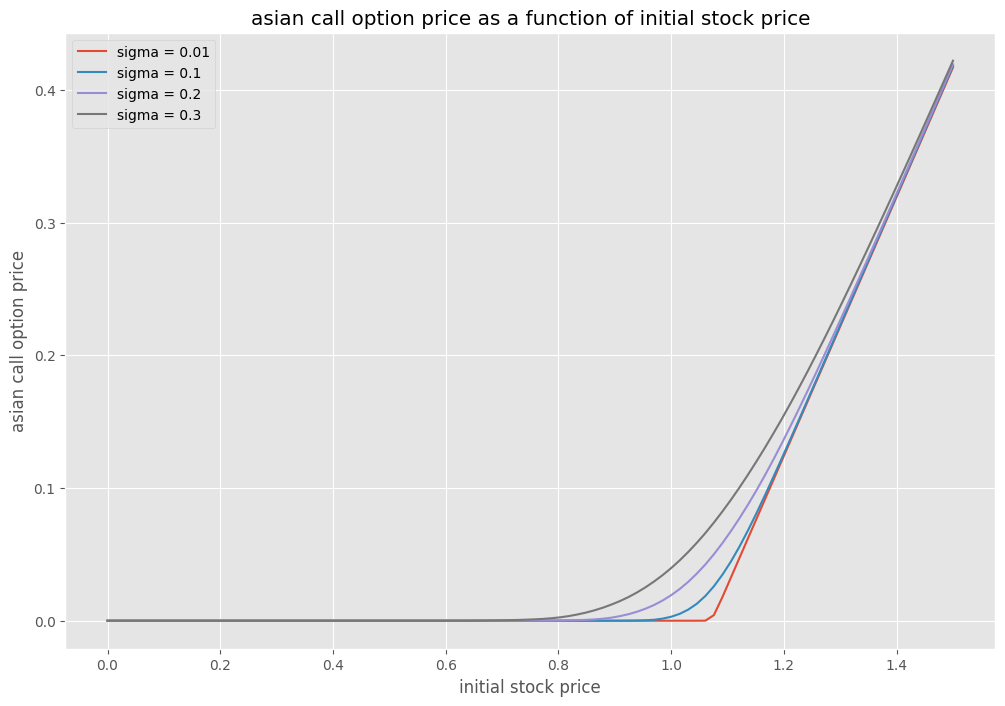

In [13]:
plt.plot(x, y, label = ['sigma = ' + str(s) for s in sigma])
plt.title('asian call option price as a function of initial stock price')
plt.xlabel('initial stock price')
plt.ylabel('asian call option price')
plt.legend();